<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Pre-requisites" data-toc-modified-id="Pre-requisites-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Pre-requisites</a></span></li><li><span><a href="#Instructions" data-toc-modified-id="Instructions-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Instructions</a></span></li><li><span><a href="#Imports-and-Constants" data-toc-modified-id="Imports-and-Constants-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Imports and Constants</a></span></li><li><span><a href="#Constants" data-toc-modified-id="Constants-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Constants</a></span></li><li><span><a href="#Export-Images" data-toc-modified-id="Export-Images-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Export Images</a></span></li></ul></div>

## Pre-requisites
Register a Google account at [https://code.earthengine.google.com](https://code.earthengine.google.com). This process may take a couple of days. Without registration, the `ee.Initialize()` command below will throw an error message.

## Instructions

This notebook exports Landsat satellite image composites of DHS and LSMS clusters from Google Earth Engine.

The images are saved in gzipped TFRecord format. By default, this notebook exports images to Google Drive. If you instead prefer to export images to Google Cloud Storage (GCS), change the `EXPORT` constant below to `'gcs'` and set `BUCKET` to the desired GCS bucket name.


|      | Storage  | Expected Export Time
|------|----------|---------------------
| DHS  | ~16.0 GB | ~24h
| LSMS |  ~2.5 GB | ~10h

The exported images take up a significant amount of storage space. Before exporting, make sure you have enough storage space. The images are exported to the following locations, based on the constants `EXPORT` and `BUCKET` defined below:

|      | Google Drive (default) | GCS
|------|:-----------------------|:---
| DHS  | `dhs_tfrecords_raw/`   | `{BUCKET}/dhs_tfrecords_raw/`
| LSMS | `lsms_tfrecords_raw/`  | `{BUCKET}/lsms_tfrecords_raw/`

Once the images have finished exporting, download the exported TFRecord files to the following folders:

- DHS: `data/dhs_tfrecords_raw/`
- LSMS: `data/lsms_tfrecords_raw/`

The folder structure should look as follows:

```
data/
    dhs_tfrecords_raw/
        angola_2011_00.tfrecord.gz
        ...
        zimbabwe_2015_00.tfrecord.gz
    lsms_tfrecords_raw/
        ethiopia_2011_00.tfrecord.gz
        ...
        uganda_2013_00.tfrecord.gz
```

## Imports and Constants

In [2]:
# ! pip install earthengine-api
%load_ext autoreload
%autoreload 2
# %matplotlib nbagg
%matplotlib inline

In [3]:
import math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from typing import Any, Dict, Optional, Tuple
from tqdm import tqdm

import ee
import pandas as pd

import ee_utils

Before using the Earth Engine API, you must perform a one-time authentication that authorizes access to Earth Engine on behalf of your Google account you registered at [https://code.earthengine.google.com](https://code.earthengine.google.com). The authentication process saves a credentials file to `$HOME/.config/earthengine/credentials` for future use.

The following command `ee.Authenticate()` runs the authentication process. Once you successfully authenticate, you may comment out this command because you should not need to authenticate again in the future, unless you delete the credentials file. If you do not authenticate, the subsequent `ee.Initialize()` command below will fail.

For more information, see [https://developers.google.com/earth-engine/python_install-conda.html](https://developers.google.com/earth-engine/python_install-conda.html).

In [2]:
ee.Authenticate()

KeyboardInterrupt: Interrupted by user

In [4]:
ee.Initialize()  # initialize the Earth Engine API

## Constants

In [5]:
# ========== ADAPT THESE PARAMETERS ==========

# To export to Google Drive, uncomment the next 2 lines
EXPORT = 'drive'
BUCKET = None

# To export to Google Cloud Storage (GCS), uncomment the next 2 lines
# and set the bucket to the desired bucket name
# EXPORT = 'gcs'
# BUCKET = 'mybucket'

# export location parameters
DHS_EXPORT_FOLDER = 'dhs_tfrecords_raw'
LSMS_EXPORT_FOLDER = 'lsms_tfrecords_raw'

In [6]:
# ========== DO NOT MODIFY THESE ==========

# input data paths
DHS_CSV_PATH = '../data/dhs_clusters.csv'
LSMS_CSV_PATH = '../data/lsms_clusters.csv'

# band names
MS_BANDS = ['BLUE', 'GREEN', 'RED', 'NIR', 'SWIR1', 'SWIR2', 'TEMP1']

# image export parameters
PROJECTION = 'EPSG:3857'  # see https://epsg.io/3857
SCALE = 30                # export resolution: 30m/px
EXPORT_TILE_RADIUS = 127  # image dimension = (2*EXPORT_TILE_RADIUS) + 1 = 255px
CHUNK_SIZE = 50         # set to a small number (<= 50) if Google Earth Engine reports memory errors

## Export Images

In [7]:
def export_images(
        df: pd.DataFrame,
        country: str,
        year: int,
        export_folder: str,
        chunk_size: Optional[int] = None,
        ) -> Dict[Tuple[Any], ee.batch.Task]:
    '''
    Args
    - df: pd.DataFrame, contains columns ['lat', 'lon', 'country', 'year']
    - country: str, together with `year` determines the survey to export
    - year: int, together with `country` determines the survey to export
    - export_folder: str, name of folder for export
    - chunk_size: int, optionally set a limit to the # of images exported per TFRecord file
        - set to a small number (<= 50) if Google Earth Engine reports memory errors

    Returns: dict, maps task name tuple (export_folder, country, year, chunk) to ee.batch.Task
    '''
    subset_df = df[(df['country'] == country) & (df['year'] == year)].reset_index(drop=True)
    if chunk_size is None:
        num_chunks = 1
    else:
        num_chunks = int(math.ceil(len(subset_df) / chunk_size))
    tasks = {}

    for i in range(num_chunks):
        chunk_slice = slice(i * chunk_size, (i+1) * chunk_size - 1)  # df.loc[] is inclusive
        fc = ee_utils.df_to_fc(subset_df.loc[chunk_slice, :])
        start_date, end_date = ee_utils.surveyyear_to_range(year)

        # create 3-year Landsat composite image
        roi = fc.geometry()
        imgcol = ee_utils.LandsatSR(roi, start_date=start_date, end_date=end_date).merged
        imgcol = imgcol.map(ee_utils.mask_qaclear).select(MS_BANDS)
        img = imgcol.median()

        # add nightlights, latitude, and longitude bands
        img = ee_utils.add_latlon(img)
        img = img.addBands(ee_utils.composite_nl(year))

        fname = f'{country}_{year}_{i:02d}'
        tasks[(export_folder, country, year, i)] = ee_utils.get_array_patches(
            img=img, scale=SCALE, ksize=EXPORT_TILE_RADIUS,
            points=fc, export='drive',
            prefix=export_folder, fname=fname,
            bucket=None)
    return tasks

In [6]:
dhs_df = pd.read_csv(DHS_CSV_PATH, float_precision='high', index_col=False).sample(5)
dhs_surveys = list(dhs_df.groupby(['country', 'year']).groups.keys())
tasks = {}

for country, year in tqdm(dhs_surveys):
    new_tasks = export_images(
        df=dhs_df, country=country, year=year,
        export_folder=DHS_EXPORT_FOLDER, chunk_size=CHUNK_SIZE)
    tasks.update(new_tasks)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.01s/it]


In [5]:
# labels = dhs_df["wealthpooled"].to_numpy()
labels = np.array([ 0.26059806, -0.531196  , -0.37570262, -0.34153277,  0.0833855 ])

In [8]:
# lsms_df = pd.read_csv(LSMS_CSV_PATH, float_precision='high', index_col=False)
# lsms_surveys = list(lsms_df.groupby(['country', 'year']).groups.keys())

# for country, year in lsms_surveys:
#     new_tasks = export_images(
#         df=lsms_df, country=country, year=year,
#         export_folder=LSMS_EXPORT_FOLDER, chunk_size=CHUNK_SIZE)
#     tasks.update(new_tasks)

Check on the status of each export task at [https://code.earthengine.google.com/](https://code.earthengine.google.com/), or run the following cell which checks every minute. Once all tasks have completed, download the DHS TFRecord files to `data/dhs_tfrecords_raw/` and LSMS TFRecord files to `data/lsms_tfrecords_raw/`.

In [7]:
ee_utils.wait_on_tasks(tasks, poll_interval=60)

  0%|          | 0/5 [00:00<?, ?it/s]

Task ('dhs_tfrecords_raw', 'burkina_faso', 2010, 0) finished in 2 min with state: COMPLETED
Task ('dhs_tfrecords_raw', 'kenya', 2014, 0) finished in 2 min with state: COMPLETED
Task ('dhs_tfrecords_raw', 'nigeria', 2010, 0) finished in 2 min with state: COMPLETED
Task ('dhs_tfrecords_raw', 'nigeria', 2015, 0) finished in 3 min with state: COMPLETED
Task ('dhs_tfrecords_raw', 'tanzania', 2010, 0) finished in 2 min with state: COMPLETED


## Visualize images

In [8]:
import sys
sys.path.append('../')
from batchers import batcher, dataset_constants
from os import listdir
from os.path import isfile, join

DATASET = '2009-17'

In [9]:
def get_images(tfrecord_paths):
    '''
    Args
    - tfrecord_paths: list of str, length N <= 32, paths of TFRecord files

    Returns: np.array, shape [N, 224, 224, 8], type float32
    '''
    init_iter, batch_op = batcher.Batcher(
        tfrecord_files=tfrecord_paths,
        dataset=DATASET,
        batch_size=32,
        ls_bands='ms',
        nl_band='merge',
        label_name='wealthpooled',
        shuffle=False,
        augment=False,
        negatives='zero',
        normalize=True).get_batch()
#     with tf.compat.v1.Session() as sess:
#         sess.run(init_iter)
#         images = sess.run(batch_op['images'])
    return batch_op['images'].numpy()

In [10]:
def plot_image_by_band(img, band_order, nrows, title, rgb=None, colorbar=False):
    '''
    Args
    - img: np.array, shape [H, W, C], type float, normalized
    - band_order: list of str, names of the bands in order
    - nrows: int, desired number of rows in the created figure
    - title: str, or None
    - rgb: one of [None, 'merge', 'add']
        - None: do not create a separate RGB image
        - 'merge': plot the RGB bands as a merged image
        - 'add': plot all bands, but also add a merged RGB image
    - colorbar: bool, whether to show colorbar
    '''
    
    nbands = img.shape[2]
    rgb_to_naxs = {
        None: nbands,
        'merge': nbands - 2,
        'add': nbands + 1
    }
    nplots = rgb_to_naxs[rgb]
    ncols = int(np.ceil(nplots / float(nrows)))
    fig_w = min(15, 3*ncols)
    fig_h = min(15, 3*nrows)
    fig, axs = plt.subplots(nrows, ncols, sharex=True, sharey=True,
                            figsize=[fig_w, fig_h], constrained_layout=True)
    if title is not None:
        fig.suptitle(title, y=1.03)
    
    # scale image to [0,1]: 0 = -3 std, 0.5 = mean, 1 = +3 std
    scaled_img = np.clip(img / 6.0 + 0.5, a_min=0, a_max=1)
    bands = {band_name: scaled_img[:, :, b] for b, band_name in enumerate(band_order)}

    plots = []
    plot_titles = []
    if rgb is not None:
        r, g, b = bands['RED'], bands['GREEN'], bands['BLUE']
        rgb_img = np.stack([r,g,b], axis=2)
        plots.append(rgb_img)
        plot_titles.append('RGB')

    if rgb == 'merge':
        for band_name in band_order:
            if band_name not in ['RED', 'GREEN', 'BLUE']:
                plots.append(bands[band_name])
                plot_titles.append(band_name)
    else:
        plots += [bands[band_name] for band_name in band_order]
        plot_titles += band_order

    for b in range(len(plots)):
        if len(axs.shape) == 1:
            ax = axs[b]
        else:
            ax = axs[b // ncols, b % ncols]
        # set origin='lower' to match lat/lon direction
        im = ax.imshow(plots[b], origin='lower', cmap='viridis', vmin=0, vmax=1)
        ax.set_aspect('equal')
        ax.axis('off')
        ax.set_title(plot_titles[b])
    
    if colorbar:
        fig.colorbar(im, orientation='vertical', ax=axs)
#     plt.show()

In [11]:
tfrecord_paths = np.asarray([f"../data/dhs_tfrecords_raw/{f}" for f in listdir("../data/dhs_tfrecords_raw") if isfile(join("../data/dhs_tfrecords_raw", f))])
tfrecord_paths

array(['../data/dhs_tfrecords_raw/nigeria_2015_00.tfrecord.gz',
       '../data/dhs_tfrecords_raw/tanzania_2010_00.tfrecord.gz',
       '../data/dhs_tfrecords_raw/nigeria_2010_00.tfrecord.gz',
       '../data/dhs_tfrecords_raw/kenya_2014_00.tfrecord.gz',
       '../data/dhs_tfrecords_raw/burkina_faso_2010_00.tfrecord.gz'],
      dtype='<U58')

In [12]:
images = get_images(tfrecord_paths)

Metal device set to: Apple M2

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-11-23 21:01:58.919294: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-23 21:01:58.920883: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-11-23 21:01:59.508714: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [13]:
print(np.shape(images))

(5, 224, 224, 8)


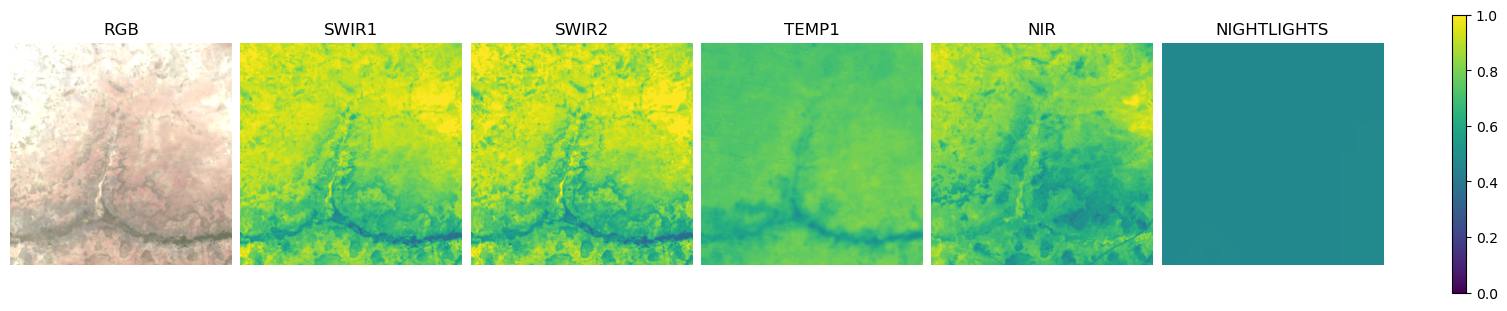

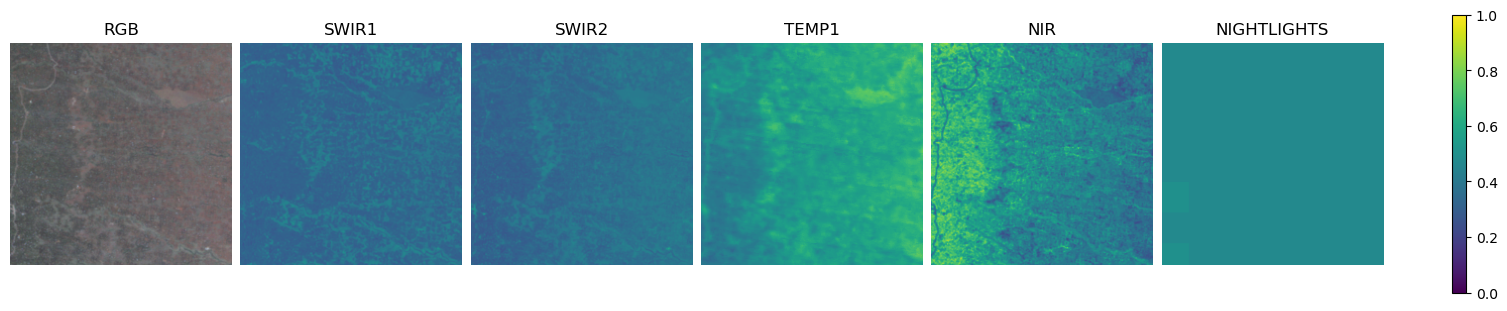

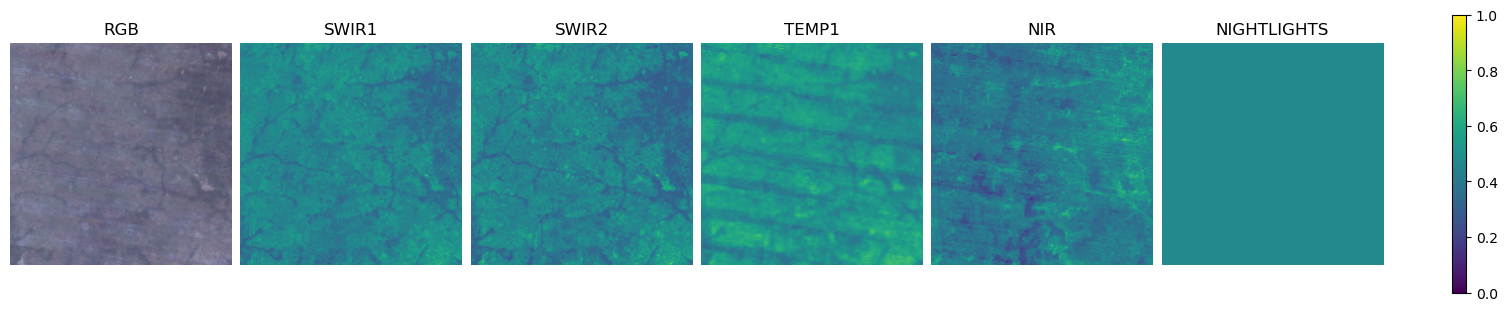

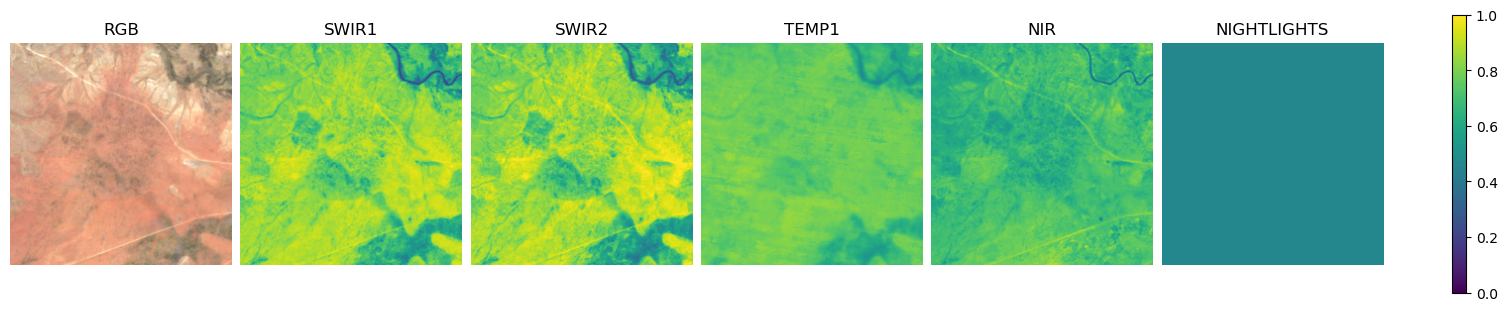

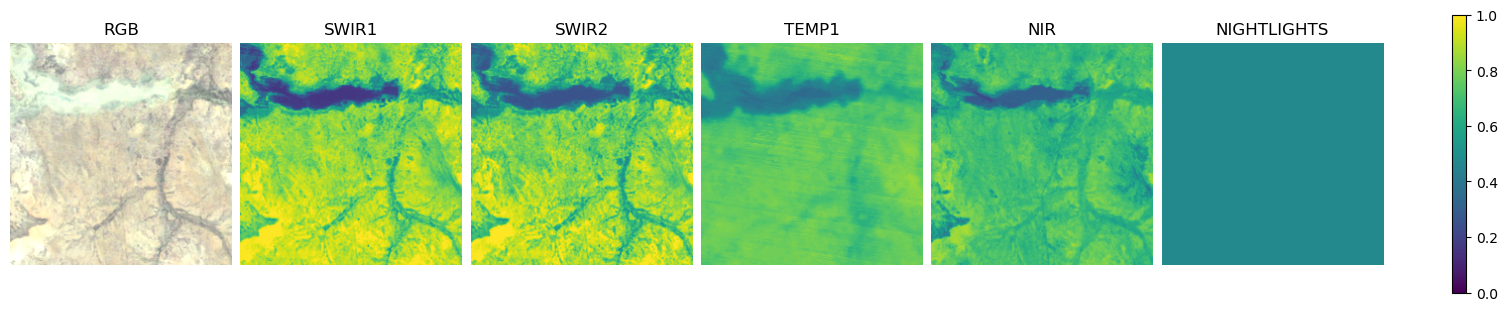

In [16]:
BAND_ORDER = ['BLUE', 'GREEN', 'RED', 'SWIR1', 'SWIR2', 'TEMP1', 'NIR', 'NIGHTLIGHTS']
# band_order = list(BAND_ORDER)  # make a copy
# band_order[-1] = 'DMSP' # if year < 2012 else 'VIIRS'
for i, img in enumerate(images):
    plot_image_by_band(img, BAND_ORDER, nrows=1, title=None, rgb="merge", colorbar=True)
    plt.show()
    # plt.savefig(f"img{i}.png")